In [1]:
import random
import datetime
import pandas as pd
import functions as ff
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,classification_report

In [2]:
furkan_images_dir = "./dataset/Furkan_Pan/images"
gamze_images_dir = "./dataset/Gamze_Pan/images"
furkan_excel_path = "./dataset/Furkan_Excel.xlsx"
gamze_excel_path = "./dataset/Gamze_Excel.xlsx"
total_excel_path = "./dataset/Total_Excel.xlsx"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = ["Hatasız","Hatalı"]

In [4]:
labels_file = pd.read_excel(total_excel_path,header=None,keep_default_na=False)
total_images_paths = ff.merge_directories(furkan_images_dir,gamze_images_dir,sort=True,fullPath=True)
img_lbl_dict = ff.create_img_label_dict(total_images_paths,labels_file,column_num=1)
pd.Series({
    "labels file length =" : len(labels_file),
    "images list length =" : len(total_images_paths),
    "dictionary  length =" : len(img_lbl_dict)
}).to_frame().style.hide(axis='columns')

In [5]:
images_paths = random.sample(total_images_paths,1400)         ## Get 1400 sample randomly for training.
print(f"For train: {len(images_paths)}, Total: {len(total_images_paths)}")

For train: 1400, Total: 1497


In [6]:
test_images = ff.getNotFoundElements(total_images_paths,images_paths)
print(f"Test images: {len(test_images)}")

Test images: 97


In [7]:
ff.display_images_labels(images_paths,img_lbl_dict)

Image  Label
0      ./dataset/Furkan_Pan/images\59.jpg      0
1     ./dataset/Furkan_Pan/images\905.jpg      1
2     ./dataset/Furkan_Pan/images\305.jpg      1
3     ./dataset/Furkan_Pan/images\692.jpg      1
4     ./dataset/Gamze_Pan/images\2710.jpg      0
...                                   ...    ...
1395  ./dataset/Furkan_Pan/images\725.jpg      1
1396  ./dataset/Gamze_Pan/images\2541.jpg      0
1397  ./dataset/Gamze_Pan/images\2268.jpg      1
1398   ./dataset/Furkan_Pan/images\62.jpg      0
1399  ./dataset/Gamze_Pan/images\3203.bmp      0

[1400 rows x 2 columns]

## Hangi resize işlemi kullanayım diye bu iki scripti çalıştırıyorum.


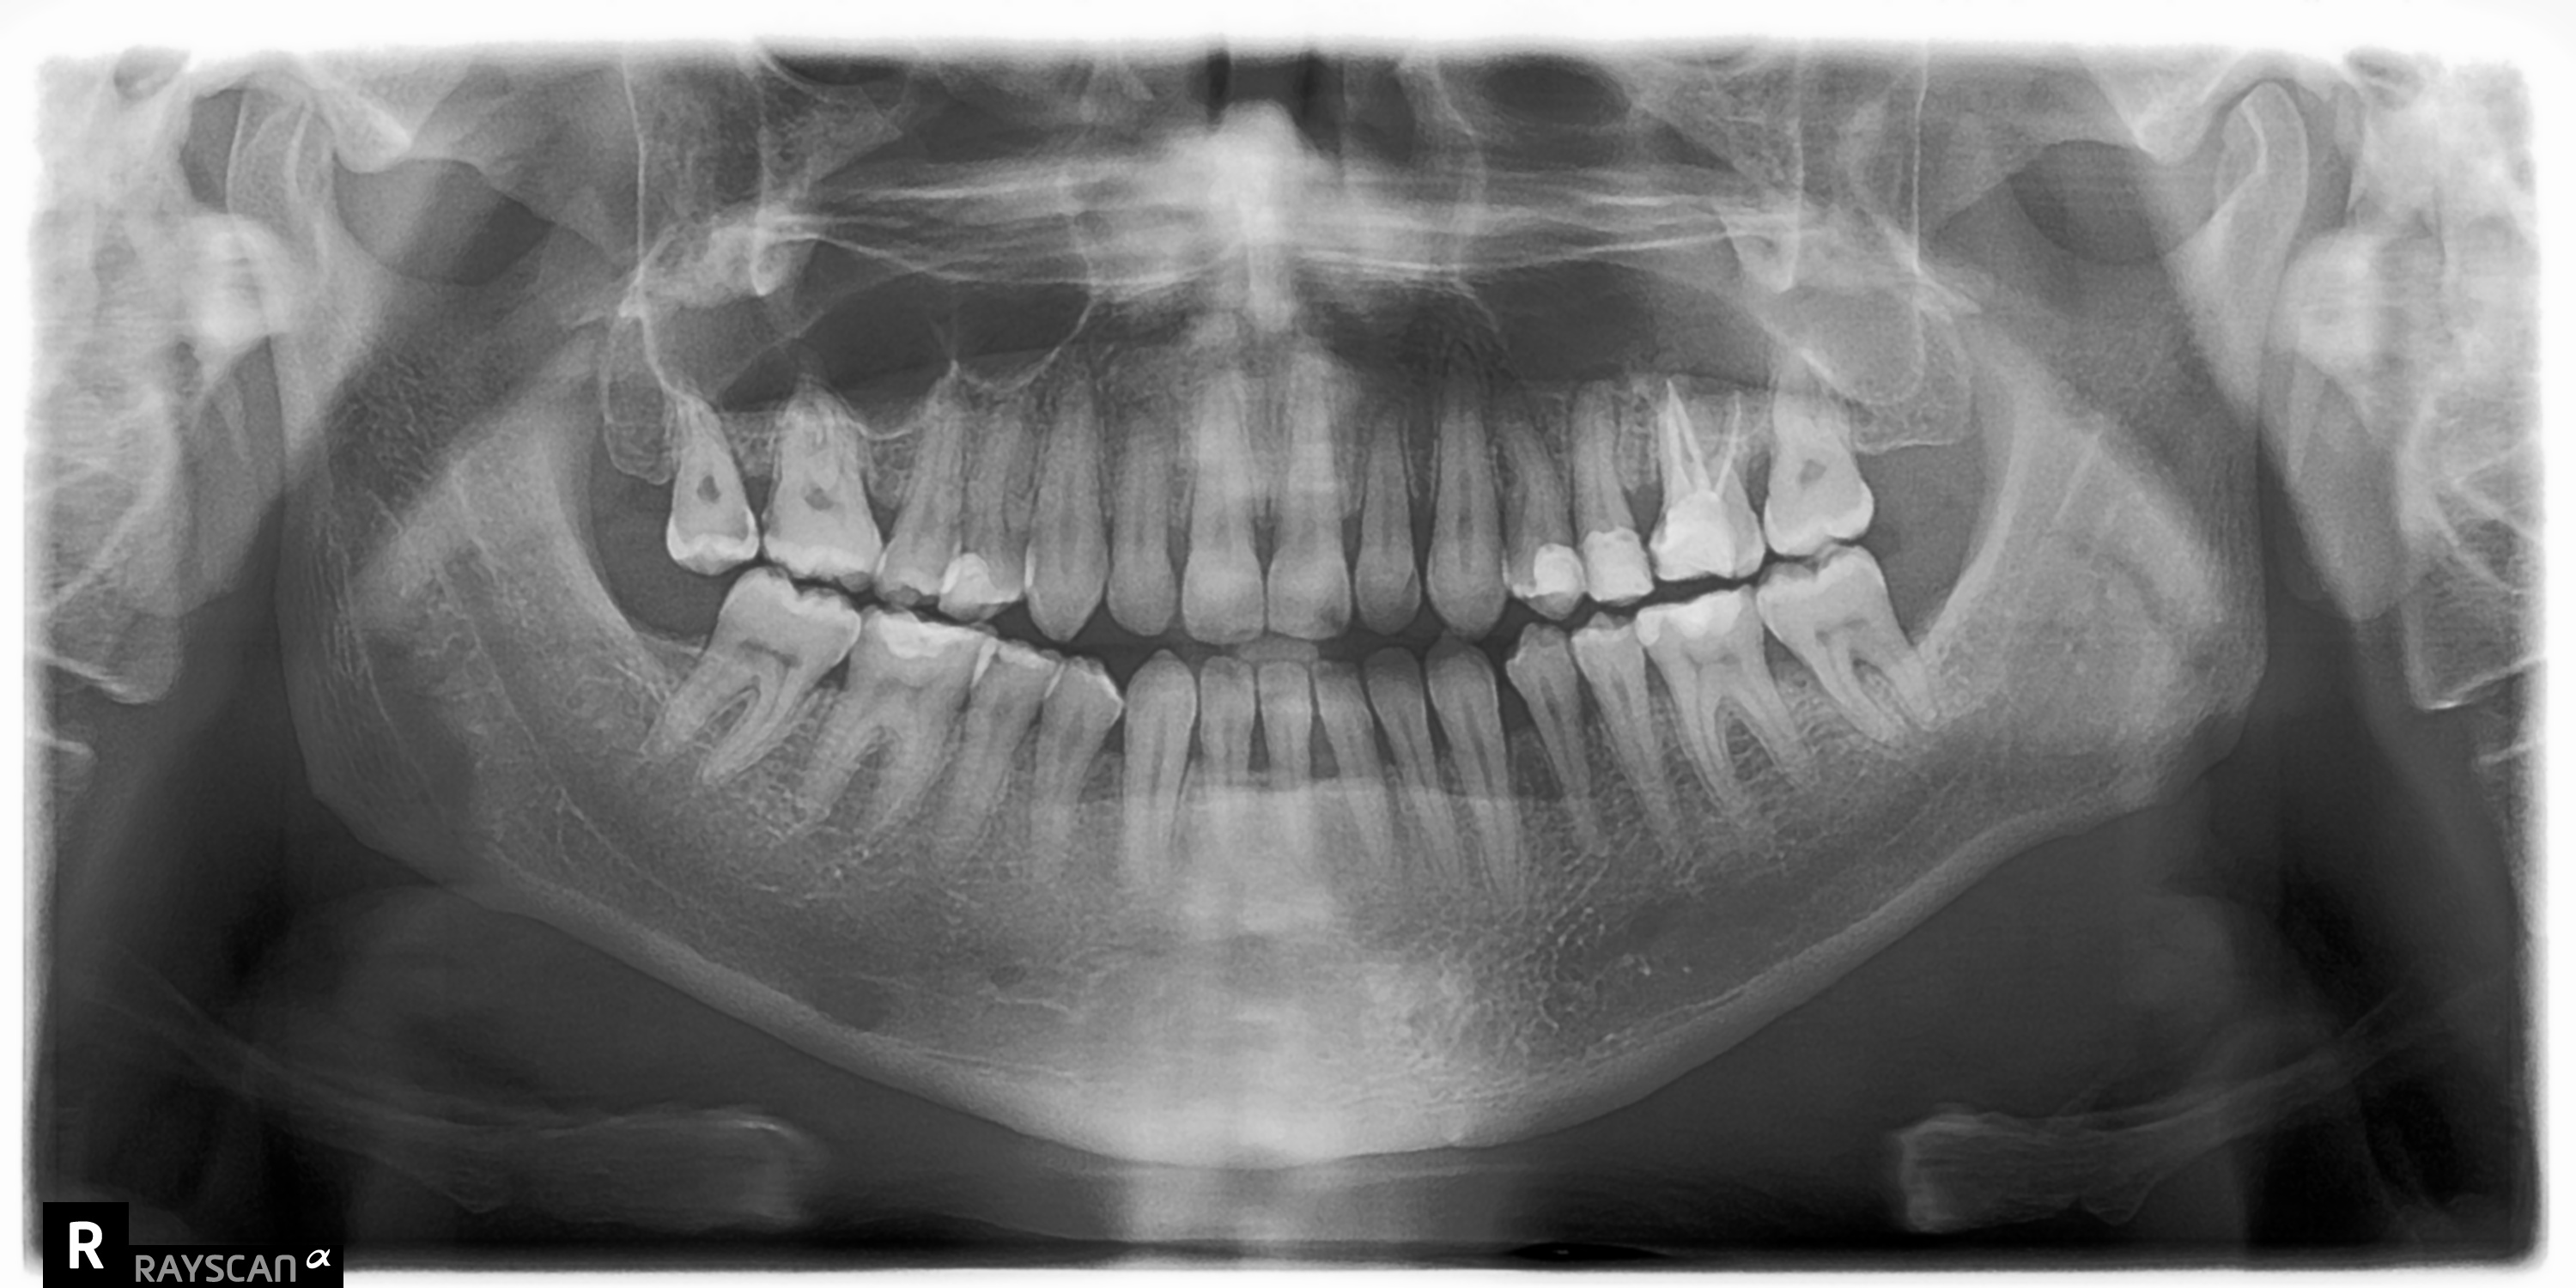

In [8]:
path = random.choice(total_images_paths)
sample = Image.open(path).convert('RGB')
sample

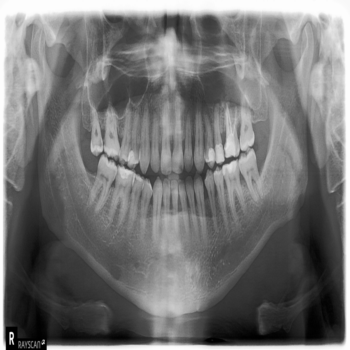

In [9]:
transformed = T.Resize((350,350))(sample)
transformed

(350, 350)


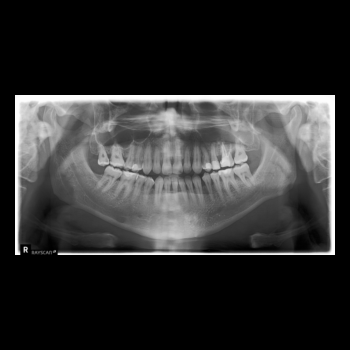

In [10]:
img, info = ff.pad_image(path)
print(info)
img

In [12]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

Using cache found in C:\Users\esamh/.cache\torch\hub\facebookresearch_dinov2_main


In [14]:
## Dataset class
class ImageDataset(Dataset):
  def __init__(self, img_paths, img_lbl_dict):
    self.img_paths = img_paths
    self.image_label_dictionary = img_lbl_dict
    self.transform = T.Compose([T.ToTensor(),T.Normalize([0.5], [0.2])])

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    image, _ = ff.pad_image(self.img_paths[idx])
    label = self.image_label_dictionary[self.img_paths[idx]]
    label = torch.tensor(label)
    image = self.transform(image)
    return image, label

## Model class
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, len(classes))
        )

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x

In [15]:
model = DinoVisionTransformerClassifier().to(device)        ## Initialize model
loss_func = nn.CrossEntropyLoss()                           ## loss function
optimizer = optim.SGD(model.parameters(),lr=0.005)          ## optimizer
batch_size = 20                                             ## batch size
num_epochs = 1                                             ## Number of epochs
K = 5                                                       ## Number of folds
kf = KFold(n_splits=K)                                      ## Define K-Fold method for cross validation

In [16]:
def run_epoch(num_epochs,epoch_id,model,device,true_lbls,predicted_lbls,dataloader,is_training):
    acc, lossValue, corrects, count= 0, 0, 0, 0
    loop = tqdm(dataloader)                                ## Show progress bar for train loop.
    ## Set model mode to train.
    model.train()
    for idx, sample in enumerate(loop):                    ## iterate whole train dataset with batches.
      ## Get images and their corresponding labels.
      imgs, labels = sample
      imgs = imgs.to(device)
      labels = labels.to(device)

      if is_training:
        optimizer.zero_grad()                             ## Reset grads to zero.

      outputs = model(imgs)                               ## make predictions

      predictions = outputs.argmax(dim=1, keepdim=True).squeeze() ## Get highest probability predicted class for each input sample.
      count += len(predictions)
      corrects += (predictions == labels).sum().item()    ## Count the correct predictions.

      ## Calculate loss value.
      loss = loss_func(outputs,labels)
      if is_training:
        loss.backward()                                   ## Calculate gradiants of the loss.
        optimizer.step()                                  ## Update optimizer parameters.

      lossValue += loss.item()                            ## Get loss value.
      acc = corrects/count
      avg_loss = lossValue/len(dataloader)

      if is_training==False and true_lbls !=None:
        true_lbls.extend(labels.tolist())
        predicted_lbls.extend(predictions.tolist())
      ## Update progress bar.
      if is_training:
        loop.set_description(f"Epoch: [{epoch_id+1}/{num_epochs}]")
      else:
        loop.set_description("Evaluation Step:")
      loop.set_postfix(Avg_Loss= avg_loss, Loss = loss.item(), Accuracy = acc)

    return acc, avg_loss

In [ ]:
## Train loop
losses = []
acc = []
true_lbls = []
predicted_lbls = []
for i, (train_index, test_index) in enumerate(kf.split(images_paths)):
  print(f"Fold {i+1}/{K}")
  ## Get select items for train/test folds.
  x_train = ff.get_selected_indexes(train_index,images_paths)
  x_test  = ff.get_selected_indexes(test_index,images_paths)

  ## Initialize train/test dataset instances.
  train_dataset = ImageDataset(x_train,img_lbl_dict)
  test_dataset = ImageDataset(x_test,img_lbl_dict)
  #print(f"train dataset length: {len(train_dataset)} , test dataset length: {len(test_dataset)}")

  ## Initialize train/test dataloaders.
  train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=2,shuffle=True)
  test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers=2,shuffle=True)
  #print(f"Number of batches in train DataLoader: {len(train_dataloader)}, Number of batches in test DataLoader: {len(test_dataloader)}")
  v_acc, v_avg_loss = None, None
  for epoch in range(0,num_epochs):
    ## Set model mode to train.
    model.train()
    _, _ = run_epoch(num_epochs,epoch,model,device,None,None,train_dataloader,True)   ## Run epoch

    ## Set model mode to evaluation.
    ## all steps like above in training mode but for evaluate model on test dataset.
    model.eval()
    with torch.no_grad():
      if epoch==num_epochs-1:
        v_acc, v_avg_loss = run_epoch(None,None,model,device,true_lbls,predicted_lbls,test_dataloader,False)        ## Evaluate model
      else:
        v_acc, v_avg_loss = run_epoch(None,None,model,device,None,None,test_dataloader,False)

  ## Store metrics.
  acc.append(v_acc)
  losses.append(v_avg_loss)


In [ ]:
## Save the model
time = datetime.datetime.now()
dir = Path("./Models/DinoV2_Models/")
dir.mkdir(parents=True,exist_ok=True)
file_name = "./Models/DinoV2_Models/DinoV2_" + str(time) + ".pth"
torch.save(model, file_name)

## Training sonucunda modelin performansı gösterme
## Aşağıdaki iki plot, her fold'un son accuracy ve loss değerleri gösterir.

In [ ]:
print("Model Performance:")
print(f"Model average loss:{sum(losses)/len(losses)}, Model average Accuracy: {100*sum(acc)/len(acc)}%")
print(classification_report(true_lbls,predicted_lbls,target_names=classes))
ff.create_cm(true_lbls,predicted_lbls,classes)

Model Performance:
Model average loss:0.7083317186151231, Model average Accuracy: 53.92857142857142%


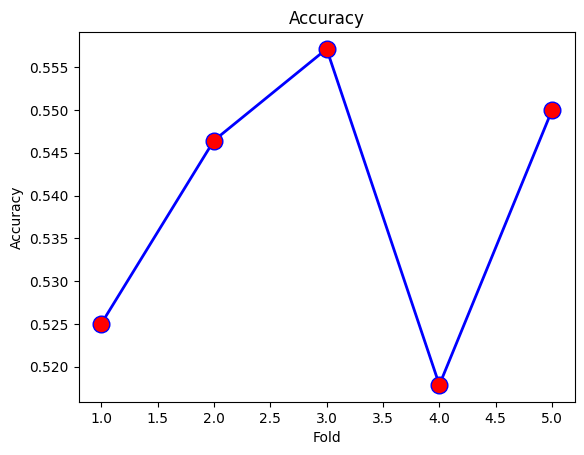

In [ ]:
plt.plot(range(1,K+1),acc,color="blue",linewidth = 2,marker='o', markerfacecolor='red', markersize=8)
plt.title("Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()

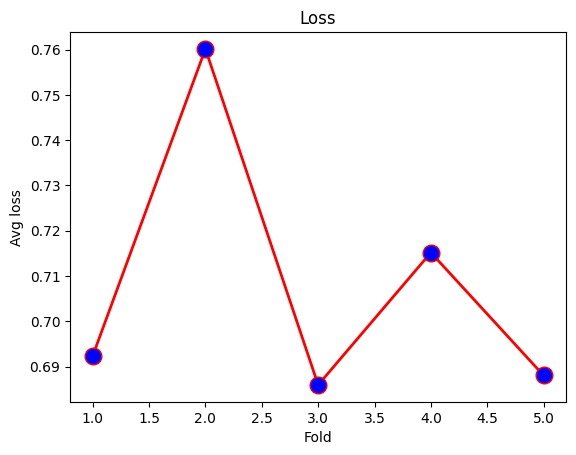

In [ ]:
plt.plot(range(1,K+1),losses,color='red',linewidth=2,marker='o', markerfacecolor='blue', markersize=8)
plt.title("Loss")
plt.xlabel("Fold")
plt.ylabel("Avg loss")
plt.show()

## Modeli test etmek için kullandım

In [ ]:
def test_model(dataset,annotation_dict,batch_size):
  test_data = ImageDataset(dataset,annotation_dict)
  test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)
  total_samples = 0
  test_labels = []
  predicted = []
  model.eval()
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(test_loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
      total_samples += len(predictions)
      test_labels.extend(labels.tolist())
      predicted.extend(predictions.tolist())
  print(f"Number of samples: {total_samples}")
  return test_labels,predicted

## Sadece 97 resim üzerinde test yapar.
Bu resimler training aşamasına dahil edilmedi.

Number of samples: 97
Accuracy: 0.5670103092783505, Precision: 0.5578947368421052, Recall: 1.0, F1 score: 0.7162162162162162


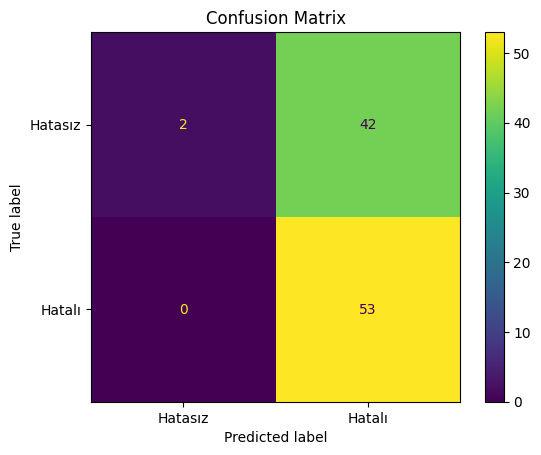

In [ ]:
t1, p1 = test_model(test_images,img_lbl_dict,batch_size)
m1=ff.calculate_metrics(t1,p1)
print(f"Accuracy: {m1[0]}, Precision: {m1[1]}, Recall: {m1[2]}, F1 score: {m1[3]}")
print(classification_report(t1,p1,target_names=classes))
ff.create_cm(t1,p1,classes)          ## Draw confusion matrix

## Bütün resimler için test

Number of samples: 1497
Accuracy: 0.5404141616566466, Precision: 0.5396505376344086, Recall: 0.9962779156327544, F1 score: 0.7000871839581517


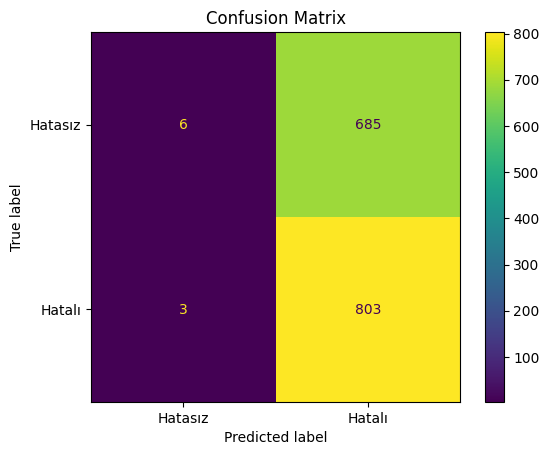

In [ ]:
t2, p2 = test_model(total_images_paths,img_lbl_dict,batch_size)
m2 = ff.calculate_metrics(t2,p2)
print(f"Accuracy: {m2[0]}, Precision: {m2[1]}, Recall: {m2[2]}, F1 score: {m2[3]}")
print(classification_report(t2,p2,target_names=classes))
ff.create_cm(t2,p2,classes)          ## Draw confusion matrix